In [9]:
import os
import torch
import pyarrow

import numpy as np
import pandas as pd
import datasets
from transformers import pipeline
import matplotlib.pyplot as plt
from sklearn import metrics

torch.set_float32_matmul_precision('high')
os.environ["TOKENIZERS_PARALLELISM"]="true"

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
register_pytree_node() got an unexpected keyword argument 'flatten_with_keys_fn'

In [10]:
import transformers

name = "hf-internal-testing/tiny-random-BartModel"

tokenizer = transformers.AutoTokenizer.from_pretrained(name)
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(name)

RuntimeError: Failed to import transformers.models.auto.tokenization_auto because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
register_pytree_node() got an unexpected keyword argument 'flatten_with_keys_fn'

In [ ]:
from compare_models import Bleurt, Mpnet, ModernBERT

In [ ]:
bleurt = Bleurt()
mpnet = Mpnet()
modernbert = ModernBERT()

In [11]:
model_name_or_path_modernbert = "answerdotai/ModernBERT-base"
model_name_or_path_mpnet = "microsoft/mpnet-base"
model_name_or_path_bleurt = "vaiibhavgupta/finetuned-bleurt-large"

In [12]:
pipe_modernbert = pipeline(
    task="text-classification", 
    model="../results/modernbert_multirc",
    tokenizer=model_name_or_path_modernbert,
    device=0,
)
 
sample = "Smoking is bad for your health."
 
pipe_modernbert(sample)

Device set to use cuda:0


[{'label': 'correct', 'score': 0.9971210360527039}]

In [11]:
pipe_mpnet = pipeline(
    task="text-classification", 
    model="../bin/mpnet_classifier",
    tokenizer=model_name_or_path_mpnet,
    device=0,
)
 
sample = "Smoking is bad for your health."
 
pipe_mpnet(sample)

Device set to use cuda:0


[{'label': 'incorrect_answer', 'score': 0.696195662021637}]

In [22]:
pipe_bleurt = pipeline(
    task="text-classification", 
    model="vaiibhavgupta/finetuned-bleurt-large",
    tokenizer=model_name_or_path_bleurt,
    device=0,
)
 
sample = "Smoking is bad for your health."
 
pipe_bleurt(sample)

# Convert label_0 to correct/incorrect

Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.2767828106880188}]

In [25]:
dataset_path = "../bin/multirc_dataset.hf"

ds = datasets.DatasetDict.load_from_disk(dataset_path)

In [26]:
# Test reference answer normalization
for sample in ds["test"]:
    try:
        response, reference = sample["text"].split("</s>")
        reference = reference.strip().removeprefix("Answer:").strip()
    except:
        print(sample["text"])

In [27]:
def get_defined_models():
    
    return {
        "ModernBERT": modernbert,
        "MPNet": mpnet,
        "BLEURT": bleurt
    }

In [28]:
models = get_defined_models()

In [31]:
pipes = {
    "Mpnet_pipe": Mpnet(),
    "Bleurt_pipe": Bleurt(),
    "ModernBERT_pipe": ModernBERT()
}

def evaluate_all_models(dataset, models, label_key="labels"):
    texts = []
    true_labels = []
    preds_dict = {name: [] for name in models.keys()}

    results_dict = {
        "input_text": texts,
        "true_label": true_labels
    }

    for example in dataset["test"]:
        text = example["text"]
        texts.append(text)

        true_label = example[label_key]
        true_labels.append(true_label)

        for name, pipe in pipes.items():
            pred_label = pipe.predict(student_response, reference) 
            preds_dict[name].append(pred)

    for name, preds in preds_dict.items():
        results_dict[f"{name}_pred"] = preds

    return pd.DataFrame(results_dict)

df_predictions = evaluate_all_models(ds, models)

df_predictions.to_csv("predicted_labels_all_models.csv", index=False)

print(df_predictions.head())

Device set to use cuda
Device set to use cuda


NameError: name 'input_text' is not defined

In [50]:
# def evaluate_all_models(dataset, models, label_key="labels"):
#     texts = []
#     true_labels = []
#     preds_dict = {name: [] for name in models.keys()}

#     for example in dataset["test"]:
#         text = example["text"]
#         response, reference = text.split("</s>")
#         reference = reference.strip().removeprefix("Answer:").strip()
#         input_text = f"{response}</s>{reference}"
#         texts.append(input_text)

#         true_label = example[label_key]
#         true_labels.append(true_label)

#         for name, model in models.items():
#             pred_label = model.predict(input_text) 
#             pred = 0 if "incorrect" in pred_label else 1
#             preds_dict[name].append(pred)

#     df = pd.DataFrame({
#         "input_text": texts,
#         "true_label": true_labels
#     })

#     for name, preds in preds_dict.items():
#         df[f"{name}_pred"] = preds

#     return df

# df_predictions = evaluate_all_models(ds, models)

# df_predictions.to_csv("predicted_labels_all_models.csv", index=False)

# print(df_predictions.head())

                                          input_text  true_label  \
0  The Women's Haven of Tarrant County</s>The Wom...           1   
1  Tarrant county shelters</s>The Women's Haven o...           0   
2  Female's Safe House of Haven County</s>The Wom...           0   
3                                California</s>Texas           0   
4                                     Texas</s>Texas           1   

   ModernBERT_pred  MPNet_pred  BLEURT_pred  
0                1           1            1  
1                1           1            1  
2                1           1            1  
3                1           1            1  
4                1           1            1  


In [33]:
modernbert_metrics = evaluate_model(pipe_modernbert, ds)
mpnet_metrics = evaluate_model(pipe_mpnet, ds)
bleurt_metrics = evaluate_model(pipe_bleurt, ds)

Token indices sequence length is longer than the specified maximum sequence length for this model (212 > 128). Running this sequence through the model will result in indexing errors


In [34]:
print("ModernBERT Metrics:")
print(f"Accuracy: {modernbert_metrics[0]:.4f}, F1 Score: {modernbert_metrics[1]:.4f}")

print("\nMPNet Metrics:")
print(f"Accuracy: {mpnet_metrics[0]:.4f}, F1 Score: {mpnet_metrics[1]:.4f}")

print("\nBLEURT Metrics:")
print(f"Accuracy: {bleurt_metrics[0]:.4f}, F1 Score: {bleurt_metrics[1]:.4f}")

ModernBERT Metrics:
Accuracy: 0.7895, F1 Score: 0.7897

MPNet Metrics:
Accuracy: 0.5492, F1 Score: 0.5286

BLEURT Metrics:
Accuracy: 0.4346, F1 Score: 0.2633


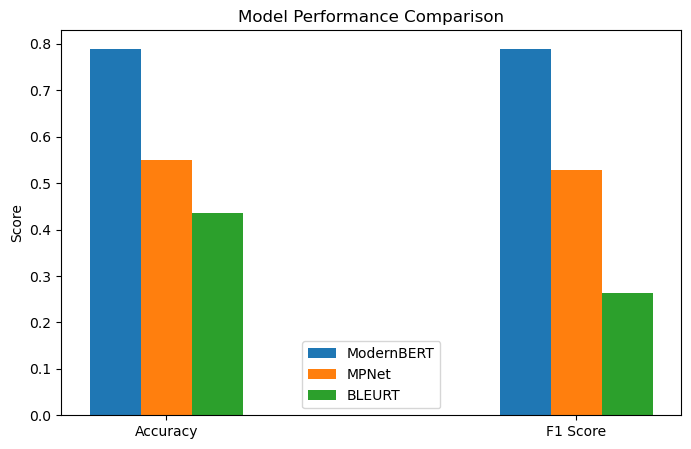

In [36]:
labels = ["Accuracy", "F1 Score"]
modernbert_values = list(modernbert_metrics)
mpnet_values = list(mpnet_metrics)
bleurt_values = list(bleurt_metrics)

x = np.arange(len(labels)) * 2 
width = 0.25 

fig, ax = plt.subplots(figsize=(8, 5)) 

rects1 = ax.bar(x - width, modernbert_values, width, label="ModernBERT")
rects2 = ax.bar(x, mpnet_values, width, label="MPNet")
rects3 = ax.bar(x + width, bleurt_values, width, label="BLEURT")

ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

NameError: name 'preds_dict' is not defined

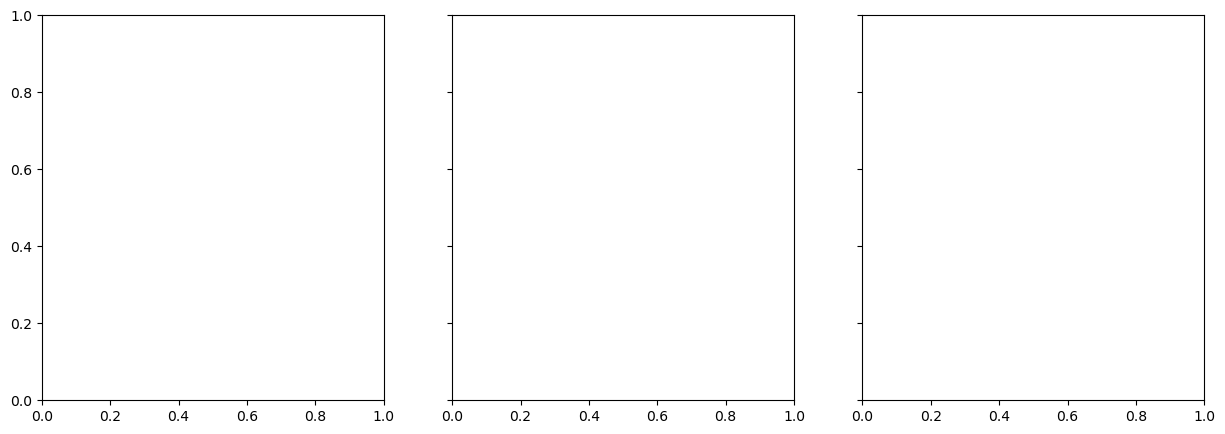

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for idx, (name, preds) in enumerate(preds_dict.items()):
    sns.heatmap(metrics.confusion_matrix(true_labels, preds), annot=True, cmap='Blues', fmt='d', ax=axes[idx])
    axes[idx].set_title(f'{name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
# def radar_plot(values, labels, model_name):
#     angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
#     values += values[:1]
#     angles += angles[:1]
#     plt.polar(angles, values, label=model_name)

# radar_plot(modernbert_values, labels, "ModernBERT")
# radar_plot(mpnet_values, labels, "MPNet")
# radar_plot(bleurt_values, labels, "BLEURT")
# plt.title("Radar/Spider Plot")
# plt.legend()
# plt.show()

In [3]:
modernbert_values = pd.Series(modernbert_values)
mpnet_values = pd.Series(mpnet_values)
bleurt_values = pd.Series(bleurt_values)

print(modernbert_values)

data = {'ModernBERT': modernbert_values, 'MPNet': mpnet_values, 'BLEURT': bleurt_values}
dfboxplt = pd.DataFrame(data, index=labels)
dfboxplt.plot(kind='box', title='Box Plot')
plt.show()

NameError: name 'modernbert_values' is not defined

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(preds_dict['ModernBERT'], preds_dict['MPNet'], alpha=0.6, label='ModernBERT vs MPNet')
plt.scatter(preds_dict['ModernBERT'], preds_dict['Bleurt'], alpha=0.6, label='ModernBERT vs BLEURT')
plt.scatter(preds_dict['MPNet'], preds_dict['Bleurt'], alpha=0.6, label='MPNet vs BLEURT')
plt.scatter(preds_dict['ModernBERT'], preds_dict['ModernBERT'], alpha=0.6, label='ModernBERT vs ModernBERT', marker='x')
plt.scatter(preds_dict['MPNet'], preds_dict['MPNet'], alpha=0.6, label='MPNet vs MPNet', marker='x')
plt.scatter(preds_dict['Bleurt'], preds_dict['Bleurt'], alpha=0.6, label='BLEURT vs BLEURT', marker='x')

plt.xlabel('Model 1 Predictions')
plt.ylabel('Model 2 Predictions')
plt.title('Model Prediction Agreement')
plt.legend()
plt.show()


NameError: name 'preds_dict' is not defined

<Figure size 800x600 with 0 Axes>

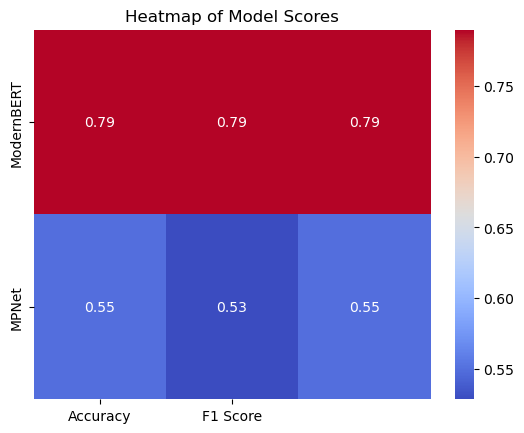

In [41]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

modernbert_values = pd.to_numeric(modernbert_values, errors='coerce')
mpnet_values = pd.to_numeric(mpnet_values, errors='coerce')
bleurt_values = pd.to_numeric(bleurt_values, errors='coerce')

data = np.vstack([modernbert_values, mpnet_values, bleurt_values])

sns.heatmap(data, annot=True, cmap="coolwarm", xticklabels=labels, yticklabels=["ModernBERT", "MPNet", "BLEURT"])
plt.title("Heatmap of Model Scores")
plt.show()

In [ ]:
# def plot_pie(values, labels, title):
#     plt.pie(values, labels=labels, autopct='%1.1f%%')
#     plt.title(title)
#     plt.show()

# plot_pie(modernbert_values, labels, "ModernBERT Scores")
# plot_pie(mpnet_values, labels, "MPNet Scores")

In [ ]:
# for name, preds in preds_dict.items():
#     correct = sum(1 for t, p in zip(true_labels, preds) if t == p)
#     incorrect = len(true_labels) - correct
#     plt.figure(figsize=(6, 6))
#     plt.pie([correct, incorrect], labels=['Correct', 'Incorrect'], autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
#     plt.title(f'{name} Correct vs Incorrect Predictions')
#     plt.show()

In [46]:
from sklearn.metrics import classification_report

def generate_classification_reports(df, models):
    
    reports = {}

    for model in models:
        preds = df[f"{model}_pred"]
        true_labels = df["true_label"]

        report = classification_report(true_labels, preds, output_dict=True)
        reports[model] = report

        print(f"\nClassification Report for {model}:\n")
        print(classification_report(true_labels, preds))

    return reports

classification_reports = generate_classification_reports(df_predictions, models)



Classification Report for ModernBERT:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2240
           1       0.43      1.00      0.61      1722

    accuracy                           0.43      3962
   macro avg       0.22      0.50      0.30      3962
weighted avg       0.19      0.43      0.26      3962


Classification Report for MPNet:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2240
           1       0.43      1.00      0.61      1722

    accuracy                           0.43      3962
   macro avg       0.22      0.50      0.30      3962
weighted avg       0.19      0.43      0.26      3962


Classification Report for BLEURT:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2240
           1       0.43      1.00      0.61      1722

    accuracy                           0.43      3962
   macro avg     

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classif

# 